In [1]:
import random
import time
from itertools import product, islice
from collections import defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

import torch
import torch.nn as nn

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
torch.set_default_dtype(torch.float64)
device

'cuda:0'

In [3]:
def get_func(model: nn.Module, loss_fn, x, y):
    def func(*p_tensors):
        assert len(list(model.parameters())) == len(p_tensors)
        assert type(model) is nn.Sequential
        i = 0
        z = x
        for module in model:
            if type(module) is nn.Linear:
                if module.bias is None:
                    z = nn.functional.linear(z, p_tensors[i], None)
                    i += 1
                else:
                    z = nn.functional.linear(z, p_tensors[i], p_tensors[i+1])
                    i += 2
            if type(module) in [nn.Tanh, nn.Sigmoid, nn.ReLU]:
                z = module(z)
        return loss_fn(z, y)
    return func

def hessian_autograd(model, loss_fn, x, y):
    H = torch.autograd.functional.hessian(get_func(model, loss_fn, x, y), tuple(model.parameters()))
    return H

def hvp_autograd(model, v, loss_fn, x, y):
    _, Hv = torch.autograd.functional.hvp(get_func(model, loss_fn, x, y), tuple(model.parameters()), v)
    return Hv

def decompose_hessian(hessian, lengths, shapes):
    H_matrix = torch.zeros(sum(lenghts), sum(lenghts))
    for i, j in product(range(len(shapes)), range(len(shapes))):
        i0, i1 = sum(lenghts[:i+1]) - lenghts[i], sum(lenghts[:i+1])
        j0, j1 = sum(lenghts[:j+1]) - lenghts[j], sum(lenghts[:j+1])
        H_matrix[i0:i1, j0:j1] = hessian[i][j].reshape(lenghts[i], lenghts[j])
    vals, vecs = torch.linalg.eigh(H_matrix)
    vs = []
    for i in range(sum(lenghts)):
        vec = vecs[:, i]
        v = tuple(vec[sum(lenghts[:i]):sum(lenghts[:i+1])].reshape(shapes[i]) for i in range(len(lenghts)))
        vs.append(v)
    return vals, vs

In [4]:
rmse_loss_fn_torch = lambda x, y: torch.sqrt(torch.mean(torch.pow(x-y, 2)))
qmqe_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 4)), 1/4)
smse_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 6)), 1/6)
mse_loss_fn_torch = nn.MSELoss()

def lp_norm(p):
    def loss(x, y):
        return torch.pow(torch.mean(torch.pow(torch.abs(x-y), p)), 1/p)
    return loss

def dl_loss(epsilon):
    def loss(x, y):
        return torch.mean(0.5 * torch.log2(1 + torch.pow((x-y) / epsilon, 2)))
    return loss

In [5]:
def loss(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    return loss_fn(mlp(x.to(device)), y).detach().cpu().numpy()

def gradient(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    loss_fn(mlp(x.to(device)), y).backward()
    grads = []
    for param in mlp.parameters():
        grads.append(param.grad.detach().clone().cpu().numpy().flatten())
        param.grad = None
    mlp.zero_grad()
    return np.concatenate(grads)

## Find eigenvalues before and after training. Fit a random 5th order polynomial.

In [6]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

In [7]:
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

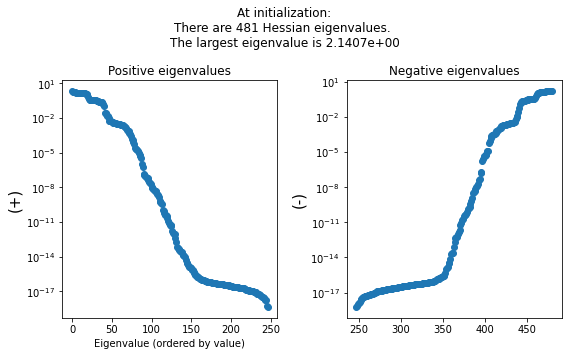

In [8]:
hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lenghts, shapes)
mlp.zero_grad()

positives = [x for x in vals.numpy() if x >= 0]
negatives = [x for x in vals.numpy() if x < 0]
positives.reverse()
negatives.reverse()

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.scatter(list(range(len(positives))), positives)
plt.yscale('log')
plt.title("Positive eigenvalues")
plt.ylabel("(+)", fontsize=15)
plt.xlabel("Eigenvalue (ordered by value)")

plt.subplot(1, 2, 2)
plt.scatter(list(range(len(positives), len(positives) + len(negatives))), np.abs(negatives))
plt.yscale('log')
plt.title("Negative eigenvalues")
plt.ylabel("(-)", fontsize=15)

plt.suptitle("At initialization:\nThere are {0:d} Hessian eigenvalues. \nThe largest eigenvalue is {1:.4e}".format(len(vals), max(positives)))

plt.tight_layout()

In [9]:
result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)
mlp.zero_grad()

         Current function value: 0.000000
         Iterations: 888
         Function evaluations: 1050
         Gradient evaluations: 1038
3.162784588022363e-07


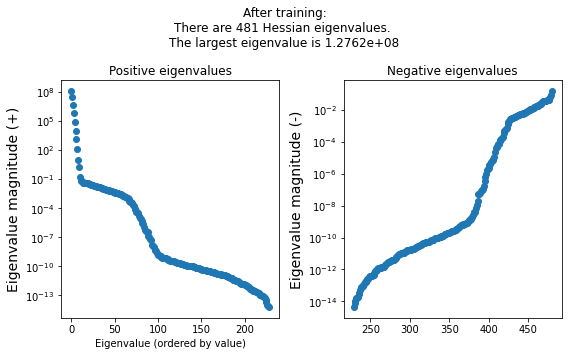

In [10]:
hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lenghts, shapes)
mlp.zero_grad()

positives = [x for x in vals.numpy() if x >= 0]
negatives = [x for x in vals.numpy() if x < 0]
positives.reverse()
negatives.reverse()

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.scatter(list(range(len(positives))), positives)
plt.yscale('log')
plt.title("Positive eigenvalues")
plt.ylabel("Eigenvalue magnitude (+)", fontsize=14)
plt.xlabel("Eigenvalue (ordered by value)")

plt.subplot(1, 2, 2)
plt.scatter(list(range(len(positives), len(positives) + len(negatives))), np.abs(negatives))
plt.yscale('log')
plt.title("Negative eigenvalues")
plt.ylabel("Eigenvalue magnitude (-)", fontsize=14)

plt.suptitle("After training:\nThere are {0:d} Hessian eigenvalues. \nThe largest eigenvalue is {1:.4e}".format(len(vals), max(positives)))

plt.tight_layout()

## Plot landscape in some eigenvector directions.

In [11]:
solution_params = [p.detach().clone() for p in mlp.parameters()]

In [12]:
iis = [0, int(0.3 * len(vals)), int(0.6 * len(vals)), len(vals) - 1]

  0%|          | 0/4 [00:00<?, ?it/s]

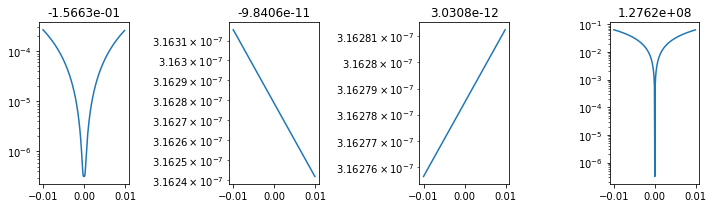

In [13]:
plt.figure(figsize=(10, 3))

for n, j in tqdm(list(enumerate(iis))):
    plt.subplot(1, 4, n+1)
    
    alphas = np.arange(-1e-2, 1e-2, 1e-4)
    losses = []
    for alpha in alphas:
        with torch.no_grad():
            for i, p in enumerate(mlp.parameters()):
                p.add_(alpha * vs[j][i].to(device))
            losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())
            for i, p in enumerate(mlp.parameters()):
                p.data = solution_params[i].clone()
    plt.plot(alphas, losses)
    plt.yscale('log')
    plt.title("{:.4e}".format(vals.numpy()[j]))

plt.tight_layout()

  0%|          | 0/3000 [00:00<?, ?it/s]

Text(0.5, 1.0, '1.2762e+08')

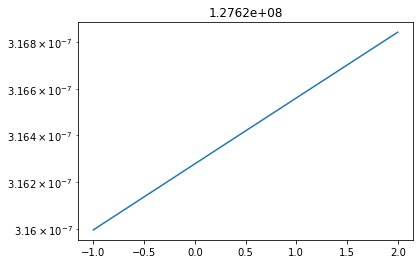

In [14]:
alphas = np.arange(-1e0, 2e0, 1e-3)
losses = []

for alpha in tqdm(alphas):
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            p.add_(alpha * vs[iis[2]][i].to(device))
        losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())
        for i, p in enumerate(mlp.parameters()):
            p.data = solution_params[i].clone()

plt.plot(alphas, losses)
plt.yscale('log')
plt.title("{:.4e}".format(vals.numpy()[j]))

  0%|          | 0/2001 [00:00<?, ?it/s]

Text(0.5, 1.0, '-1.5663e-01')

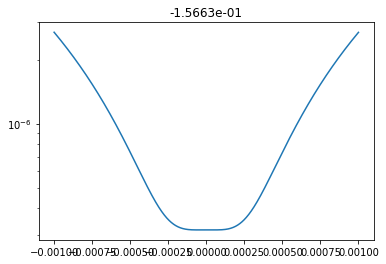

In [15]:
alphas = np.arange(-1e-3, 1e-3, 1e-6)
losses = []

for alpha in tqdm(alphas):
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            p.add_(alpha * vs[0][i].to(device))
        losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())
        for i, p in enumerate(mlp.parameters()):
            p.data = solution_params[i].clone()

plt.plot(alphas, losses)
plt.yscale('log')
plt.title("{:.4e}".format(vals.numpy()[0]))

In [16]:
min(losses)

3.161254979740016e-07

## Repeat but for a neural network teacher target function

In [17]:
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
x_i = torch.from_numpy(x_i).to(device)

teacher = nn.Sequential(
    nn.Linear(1, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1)
).to(device)

with torch.no_grad():
    y_i = teacher(x_i)

In [18]:
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

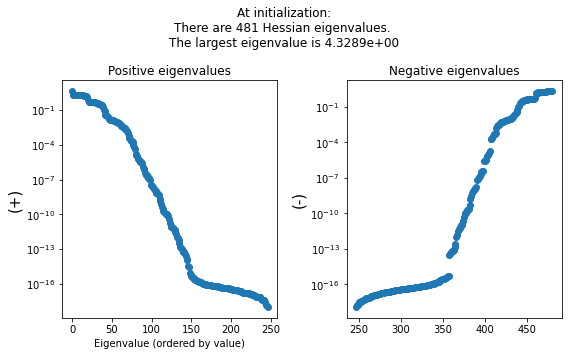

In [19]:
hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lenghts, shapes)
mlp.zero_grad()

positives = [x for x in vals.numpy() if x >= 0]
negatives = [x for x in vals.numpy() if x < 0]
positives.reverse()
negatives.reverse()

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.scatter(list(range(len(positives))), positives)
plt.yscale('log')
plt.title("Positive eigenvalues")
plt.ylabel("(+)", fontsize=15)
plt.xlabel("Eigenvalue (ordered by value)")

plt.subplot(1, 2, 2)
plt.scatter(list(range(len(positives), len(positives) + len(negatives))), np.abs(negatives))
plt.yscale('log')
plt.title("Negative eigenvalues")
plt.ylabel("(-)", fontsize=15)

plt.suptitle("At initialization:\nThere are {0:d} Hessian eigenvalues. \nThe largest eigenvalue is {1:.4e}".format(len(vals), max(positives)))

plt.tight_layout()

In [20]:
result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = rmse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)
mlp.zero_grad()

         Current function value: 0.000000
         Iterations: 208
         Function evaluations: 285
         Gradient evaluations: 273
2.8829895500165246e-09


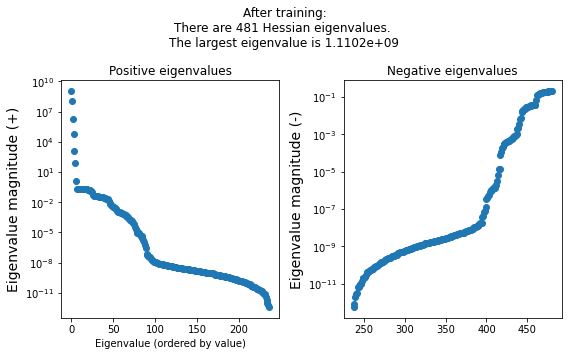

In [21]:
hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lenghts, shapes)
mlp.zero_grad()

positives = [x for x in vals.numpy() if x >= 0]
negatives = [x for x in vals.numpy() if x < 0]
positives.reverse()
negatives.reverse()

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.scatter(list(range(len(positives))), positives)
plt.yscale('log')
plt.title("Positive eigenvalues")
plt.ylabel("Eigenvalue magnitude (+)", fontsize=14)
plt.xlabel("Eigenvalue (ordered by value)")

plt.subplot(1, 2, 2)
plt.scatter(list(range(len(positives), len(positives) + len(negatives))), np.abs(negatives))
plt.yscale('log')
plt.title("Negative eigenvalues")
plt.ylabel("Eigenvalue magnitude (-)", fontsize=14)

plt.suptitle("After training:\nThere are {0:d} Hessian eigenvalues. \nThe largest eigenvalue is {1:.4e}".format(len(vals), max(positives)))

plt.tight_layout()

### Let's look at the spectrum at the global minimum

In [22]:
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
x_i = torch.from_numpy(x_i).to(device)

teacher = nn.Sequential(
    nn.Linear(1, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
).to(device)

target_params = dict((name, p.detach().clone()) for name, p in teacher.named_parameters())

with torch.no_grad():
    y_i = teacher(x_i)
    
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

for name, p in mlp.named_parameters():
    p.data = target_params[name].clone() + 1e-12 * torch.randn(p.shape).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [23]:
with torch.no_grad():
    print(rmse_loss_fn_torch(mlp(x_i), y_i).item())

2.608330166215483e-12


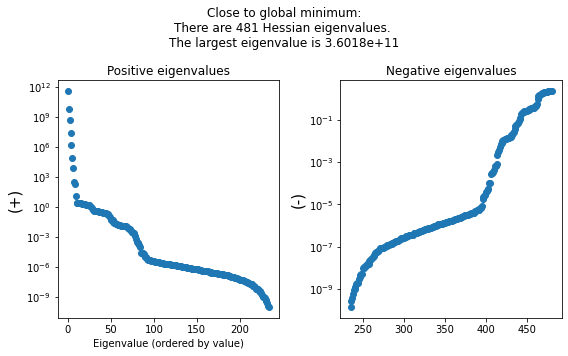

In [24]:
hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lenghts, shapes)
mlp.zero_grad()

positives = [x for x in vals.numpy() if x >= 0]
negatives = [x for x in vals.numpy() if x < 0]
positives.reverse()
negatives.reverse()

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.scatter(list(range(len(positives))), positives)
plt.yscale('log')
plt.title("Positive eigenvalues")
plt.ylabel("(+)", fontsize=15)
plt.xlabel("Eigenvalue (ordered by value)")

plt.subplot(1, 2, 2)
plt.scatter(list(range(len(positives), len(positives) + len(negatives))), np.abs(negatives))
plt.yscale('log')
plt.title("Negative eigenvalues")
plt.ylabel("(-)", fontsize=15)

plt.suptitle("Close to global minimum:\nThere are {0:d} Hessian eigenvalues. \nThe largest eigenvalue is {1:.4e}".format(len(vals), max(positives)))

plt.tight_layout()

### Let's look at scaling relationship between top eigenvalue and distance from minimuim

In [25]:
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
x_i = torch.from_numpy(x_i).to(device)

teacher = nn.Sequential(
    nn.Linear(1, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
).to(device)

target_params = dict((name, p.detach().clone()) for name, p in teacher.named_parameters())

with torch.no_grad():
    y_i = teacher(x_i)
    
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

In [26]:
ds = [1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
tops = []
neg_fracs = []
for d in tqdm(ds):
    for name, p in mlp.named_parameters():
        p.data = target_params[name].clone() + d * torch.randn(p.shape).to(device)

    params = []
    shapes = []
    lenghts = []
    for param in mlp.parameters():
        param_np = param.data.detach().clone().cpu().numpy()
        shapes.append(param_np.shape)
        param_np_flat = param_np.flatten()
        lenghts.append(len(param_np_flat))
        params.append(param_np_flat)

    param_vector = np.concatenate(params)
    
    hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
    vals, vs = decompose_hessian(hessian, lenghts, shapes)
    mlp.zero_grad()
    neg_frac = len([x for x in vals.numpy() if x < 0.0]) / len(vals)
    neg_fracs.append(neg_frac)
    top_eigenvalue = max(vals.numpy())
    tops.append(top_eigenvalue)

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0, 0.5, 'largest Hessian eigenvalue')

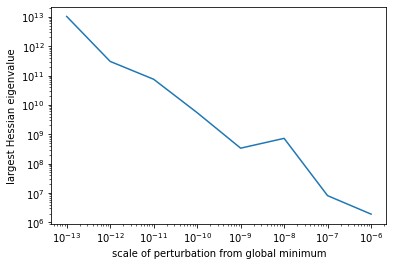

In [27]:
plt.plot(ds, tops)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("scale of perturbation from global minimum")
plt.ylabel("largest Hessian eigenvalue")

Text(0, 0.5, 'fraction of Hessian eigenvalues which are negative')

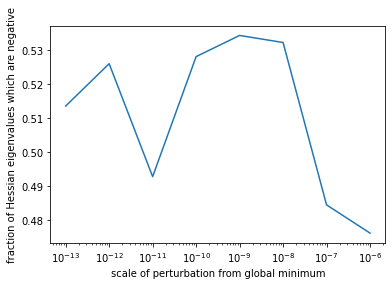

In [28]:
plt.plot(ds, neg_fracs)
# plt.yscale('log')
plt.xscale('log')
plt.xlabel("scale of perturbation from global minimum")
plt.ylabel("fraction of Hessian eigenvalues which are negative")